In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, f_oneway, kruskal, kstest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scikit_posthocs import posthoc_dunn
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from scipy.stats import chi2_contingency


In [28]:
alpha = 0.05

def t_test(popularity_class, dist_1, dist_2):
    dist_1_class = dist_1[popularity_class]
    dist_2_class = dist_2[popularity_class]
    _, p_value = ttest_ind(dist_1_class, dist_2_class)
    return p_value

def kolmogorov_smirnov_test(popularity_class, dist_1, dist_2):
    dist_1_class = dist_1[popularity_class]
    dist_2_class = dist_2[popularity_class]
    _, p_value = kstest(dist_1_class, dist_2_class)
    return p_value

# Calculate effect sizes to quantify the magnitude of the differences
# around 0.2 is a small effect, 0.5 a medium effect, 0.8 large effect
# source https://machinelearningmastery.com/effect-size-measures-in-python/
def cohen_d(dist_1, dist_2):
    mean_diff = np.mean(dist_1) - np.mean(dist_2)
    pooled_std = np.sqrt(
        (np.std(dist_1, ddof = 1) ** 2 + \
         np.std(dist_2, ddof = 1) ** 2) / 2)
    cohen_d = mean_diff / pooled_std 
    return cohen_d 

# Perform chi-square test
def perform_chi_square_test(contingency_table, popularity_class):
    print(f"Chi-square test for {popularity_class}:")
    _, p_value, _, expected  = chi2_contingency(contingency_table)
    print(f"p-value: {np.round(p_value, 5)}")
    if p_value < alpha:
        print("Statistically significant difference") 
        residuals = (contingency_table - expected) / np.sqrt(expected)

        # Print residuals
        print("- Residuals:")
        print(residuals, "\n")
    else:
        print("No statistically significant difference\n") 

### Read Data

In [2]:
train = pd.read_csv(r"C:\\Users\\joana\\Documents\\GitHub\\CSCI6405\\src\\data\\train.csv")
val = pd.read_csv(r"C:\\Users\\joana\\Documents\\GitHub\\CSCI6405\\src\\data\\val.csv")
test = pd.read_csv(r"C:\\Users\\joana\\Documents\\GitHub\\CSCI6405\\src\\data\\test.csv")
all_data = pd.concat([train, val, test], axis = 0)
all_data.head()

,title,upvotes,edited,original,self,locked,comments,nsfw,self_text,spoiler,...,downvotes,title_length,text_length,title_sentiment,text_sentiment,video,image,upvote_popular,downvote_popular,comments_popular
0,Want to take a long sleep and never wake up.,11,True,False,True,False,2,True,I am 18(M) and I am a senior in high-school. I...,False,...,1,44,1133,positive,positive,False,False,0,0,0
1,Buspirone,6,False,False,True,False,10,False,"Hey, I had pretty severe GAD (generalized anxi...",False,...,0,9,328,neutral,negative,False,False,0,0,0
2,Has anyone else found that you feel you don’t ...,175,False,False,True,False,28,False,NaN,False,...,0,120,0,positive,negative,False,False,0,0,1
3,I have become a very resentful person and idk ...,70,False,False,True,False,28,False,25f. Due to several recent circumstances and a...,False,...,0,62,510,negative,negative,False,False,0,0,1
4,Posting this before I put a hole in my car doo...,1,False,False,True,False,0,False,Title basically says it all. It’s a frequent i...,False,...,0,176,1068,negative,negative,False,False,0,0,0


In [6]:
all_data['upvote_popular'] = all_data.upvote_popular.astype(bool)
all_data['downvote_popular'] = all_data.downvote_popular.astype(bool)
all_data['comments_popular'] = all_data.comments_popular.astype(bool)

#### Hypothesis I: Posts that are shorter in content lead to higher popularity

In [5]:
df_h1 = all_data[['text_length', 'upvote_popular', 
                  'downvote_popular', 'comments_popular']]
df_h1.head()

,text_length,upvote_popular,downvote_popular,comments_popular
0,1133,False,False,False
1,328,False,False,False
2,0,False,False,True
3,510,False,False,True
4,1068,False,False,False


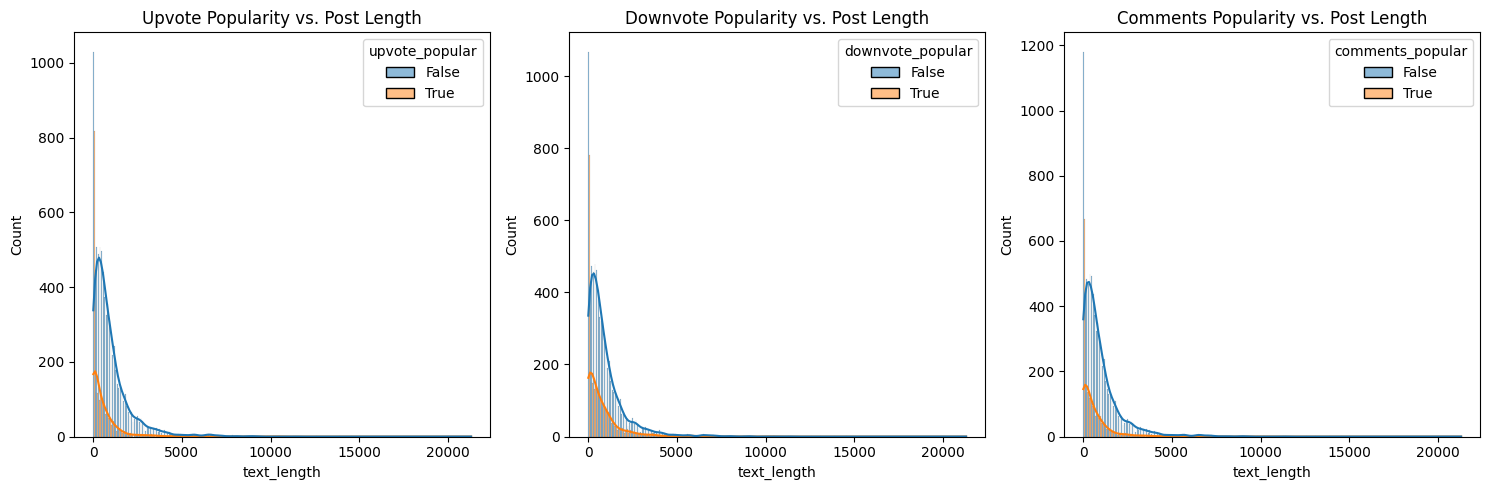

In [6]:
# All posts
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(data=df_h1, x='text_length', hue='upvote_popular', kde=True, multiple='dodge')
plt.title('Upvote Popularity vs. Post Length')

plt.subplot(1, 3, 2)
sns.histplot(data=df_h1, x='text_length', hue='downvote_popular', kde=True, multiple='dodge')
plt.title('Downvote Popularity vs. Post Length')

plt.subplot(1, 3, 3)
sns.histplot(data=df_h1, x='text_length', hue='comments_popular', kde=True, multiple='dodge')
plt.title('Comments Popularity vs. Post Length')

plt.tight_layout()
plt.show()

In [7]:
df_h1.describe()

,text_length
count,10000.000000
mean,895.202500
std,1167.673969
min,0.000000
25%,189.750000
50%,561.500000
75%,1149.000000
max,21312.000000


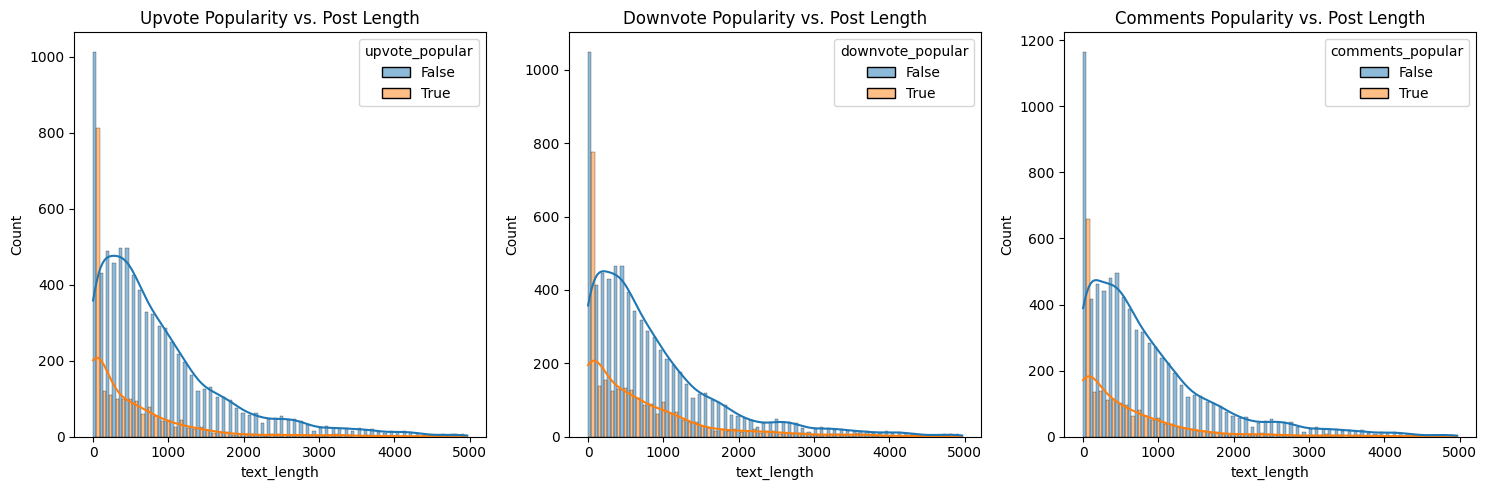

In [8]:
# Medium posts
medium_posts = df_h1[df_h1['text_length'] <= 5000]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(data=medium_posts, x='text_length', hue='upvote_popular', kde=True, multiple='dodge')
plt.title('Upvote Popularity vs. Post Length')

plt.subplot(1, 3, 2)
sns.histplot(data=medium_posts, x='text_length', hue='downvote_popular', kde=True, multiple='dodge')
plt.title('Downvote Popularity vs. Post Length')

plt.subplot(1, 3, 3)
sns.histplot(data=medium_posts, x='text_length', hue='comments_popular', kde=True, multiple='dodge')
plt.title('Comments Popularity vs. Post Length')

plt.tight_layout()
plt.show()

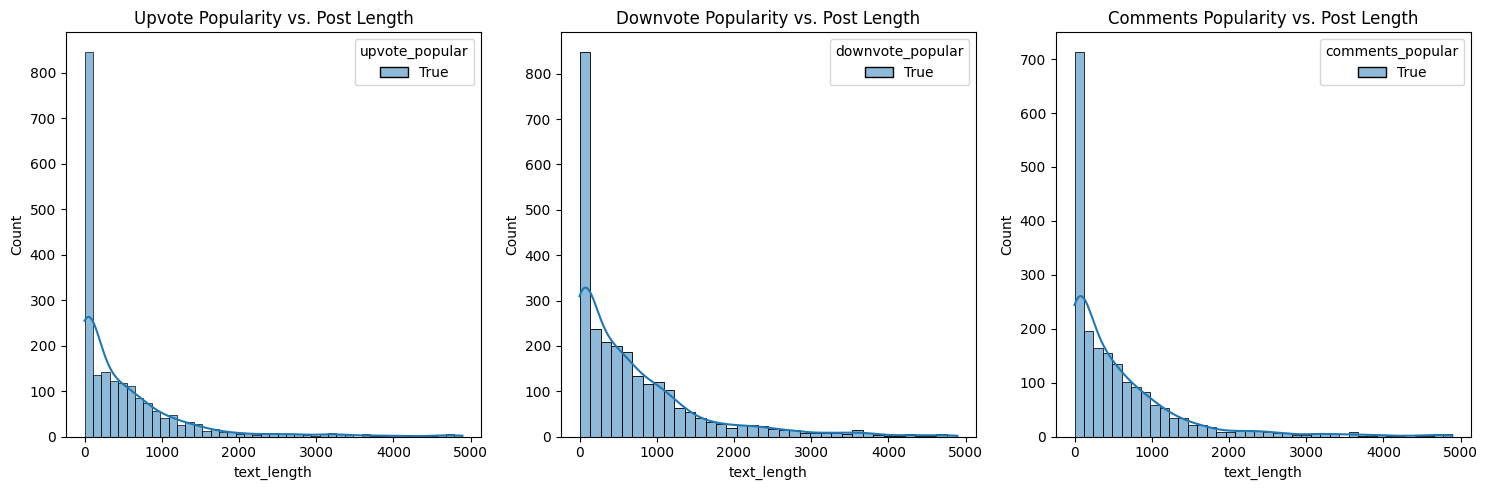

In [9]:
# Medium posts for True label
medium_posts = df_h1[df_h1['text_length'] <= 5000]
upvote_popular = medium_posts[medium_posts['upvote_popular'] == True]
downvote_popular = medium_posts[medium_posts['downvote_popular'] == True]
comments_popular = medium_posts[medium_posts['comments_popular'] == True]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(data=upvote_popular, x='text_length', hue='upvote_popular', kde=True, multiple='dodge')
plt.title('Upvote Popularity vs. Post Length')

plt.subplot(1, 3, 2)
sns.histplot(data=downvote_popular, x='text_length', hue='downvote_popular', kde=True, multiple='dodge')
plt.title('Downvote Popularity vs. Post Length')

plt.subplot(1, 3, 3)
sns.histplot(data=comments_popular, x='text_length', hue='comments_popular', kde=True, multiple='dodge')
plt.title('Comments Popularity vs. Post Length')

plt.tight_layout()
plt.show()

C:\Users\joana\AppData\Local\Temp\ipykernel_18556\2662938447.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


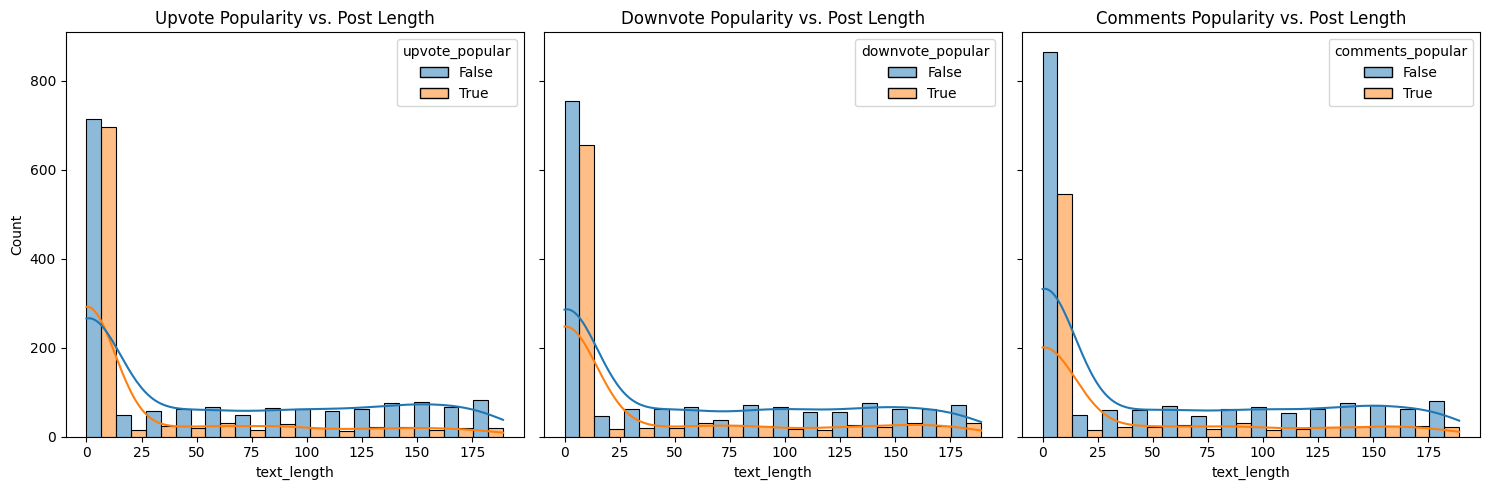

In [10]:
# Shorter posts (25%)
short_posts = df_h1[df_h1['text_length'] <= 189]
fig, ax =plt.subplots(1, 3, sharex = 'all', sharey = True, figsize=(15, 5))

sns.histplot(data=short_posts, x='text_length', hue='upvote_popular', kde=True, multiple='dodge', ax = ax[0])
ax[0].set_title('Upvote Popularity vs. Post Length')

sns.histplot(data=short_posts, x='text_length', hue='downvote_popular', kde=True, multiple='dodge', ax = ax[1])
ax[1].set_title('Downvote Popularity vs. Post Length')

sns.histplot(data=short_posts, x='text_length', hue='comments_popular', kde=True, multiple='dodge', ax = ax[2])
ax[2].set_title('Comments Popularity vs. Post Length')

plt.tight_layout()
fig.show()

In [11]:
short_posts.shape

(2500, 4)

In [12]:
long_posts = df_h1[df_h1['text_length'] > 189]
short_posts = df_h1[df_h1['text_length'] <= 189]

for popularity_class in ['upvote_popular', 'downvote_popular', 'comments_popular']:
    p_value = t_test(popularity_class, short_posts, long_posts)
    print(f"T-test for {popularity_class}:")
    print(f"p-value: {np.round(p_value, 5)}")
    if p_value < alpha:
        print("Statistically significant difference\n")
    else:
        print("No statistically significant difference\n")

    p_value = kolmogorov_smirnov_test(popularity_class, short_posts, long_posts)
    print(f"KS-test for {popularity_class}:")
    print(f"p-value: {np.round(p_value, 5)}")
    if p_value < alpha:
        print("Statistically significant difference\n") # difference in popularity is likely due to post length.
    else:
        print("No statistically significant difference\n") # opposite

    
    _, p_value = kruskal(
        short_posts[popularity_class], 
        long_posts[popularity_class]
    )
    print(f"Kruskal-Wallis test for {popularity_class}:")
    print(f"p-value: {np.round(p_value, 5)}")
    if p_value < alpha:
        print("Statistically significant difference\n") 
    else:
        print("No statistically significant difference\n") 

        
    _, p_value = f_oneway(
        short_posts[popularity_class], 
        long_posts[popularity_class]
    )
    print(f"ANOVA test for {popularity_class}:")
    print(f"p-value: {np.round(p_value, 5)}")
    if p_value < alpha:
        print("Statistically significant difference\n") 
    else:
        print("No statistically significant difference\n")

T-test for upvote_popular:
p-value: 0.0
Statistically significant difference

KS-test for upvote_popular:
p-value: 0.0
Statistically significant difference

Kruskal-Wallis test for upvote_popular:
p-value: 0.0
Statistically significant difference

ANOVA test for upvote_popular:
p-value: 0.0
Statistically significant difference

T-test for downvote_popular:
p-value: 0.0
Statistically significant difference

KS-test for downvote_popular:
p-value: 0.0
Statistically significant difference

Kruskal-Wallis test for downvote_popular:
p-value: 0.0
Statistically significant difference

ANOVA test for downvote_popular:
p-value: 0.0
Statistically significant difference

T-test for comments_popular:
p-value: 0.0
Statistically significant difference

KS-test for comments_popular:
p-value: 0.0
Statistically significant difference

Kruskal-Wallis test for comments_popular:
p-value: 0.0
Statistically significant difference

ANOVA test for comments_popular:
p-value: 0.0
Statistically significant differ

In [13]:
print("Cohen d for upvote_popular:", 
      np.round(cohen_d(short_posts['upvote_popular'], long_posts['upvote_popular']), 2)) 

print("Cohen d for downvote_popular:", 
      np.round(cohen_d(short_posts['downvote_popular'], long_posts['downvote_popular']), 2)) 

print("Cohen d for comments_popular:", 
      np.round(cohen_d(short_posts['comments_popular'], long_posts['comments_popular']), 2))

Cohen d for upvote_popular: 0.56
Cohen d for downvote_popular: 0.34
Cohen d for comments_popular: 0.4


#### Hypothesis II: Uplifting posts receive more user interaction than those considered as venting or seeking advice.

In [22]:
df_h2 = all_data[['text_sentiment', 'title_sentiment', 'upvote_popular', 
                  'downvote_popular', 'comments_popular']]

df_h2.head()

,text_sentiment,title_sentiment,upvote_popular,downvote_popular,comments_popular
0,positive,positive,False,False,False
1,negative,neutral,False,False,False
2,negative,positive,False,False,True
3,negative,negative,False,False,True
4,negative,negative,False,False,False


In [29]:
pos_text = df_h2[df_h2['text_sentiment'] == 'positive']
neg_text = df_h2[df_h2['text_sentiment'] == 'negative']
neut_text = df_h2[df_h2['text_sentiment'] == 'neutral']

# Text Sentiment Contingency Tables
## Up-vote 
ct_text_up = [pos_text[['upvote_popular']].value_counts().to_list(),
              neg_text[['upvote_popular']].value_counts().to_list(),
              neut_text[['upvote_popular']].value_counts().to_list()] 

## Down-vote  
ct_text_down = [pos_text[['downvote_popular']].value_counts().to_list(),
                neg_text[['downvote_popular']].value_counts().to_list(),
                neut_text[['downvote_popular']].value_counts().to_list()] 

## Comments 
ct_text_coms = [pos_text[['comments_popular']].value_counts().to_list(),
                neg_text[['comments_popular']].value_counts().to_list(),
                neut_text[['comments_popular']].value_counts().to_list()] 


perform_chi_square_test(ct_text_up, 'upvote_popular')
perform_chi_square_test(ct_text_down, 'downvote_popular')
perform_chi_square_test(ct_text_coms, 'comments_popular')


Chi-square test for upvote_popular:
p-value: 0.0369
Statistically significant difference
- Residuals:
[[ 0.91437212 -1.81289497]
 [-0.7079399   1.40360873]
 [ 0.03267626 -0.06478612]] 

Chi-square test for downvote_popular:
p-value: 0.0012
Statistically significant difference
- Residuals:
[[ 1.4371857  -2.3959612 ]
 [-1.17707958  1.96233305]
 [ 0.32665546 -0.54457389]] 

Chi-square test for comments_popular:
p-value: 0.14659
No statistically significant difference



In [3]:
sns.__version__

'0.13.2'

In [30]:
pos_title = df_h2[df_h2['title_sentiment'] == 'positive']
neg_title = df_h2[df_h2['title_sentiment'] == 'negative']
neut_title = df_h2[df_h2['title_sentiment'] == 'neutral']

# Title Sentiment Contingency Tables
## Up-vote 
ct_title_up = [pos_title[['upvote_popular']].value_counts().to_list(),
              neg_title[['upvote_popular']].value_counts().to_list(),
              neut_title[['upvote_popular']].value_counts().to_list()] 

## Down-vote  
ct_title_down = [pos_title[['downvote_popular']].value_counts().to_list(),
                neg_title[['downvote_popular']].value_counts().to_list(),
                neut_title[['downvote_popular']].value_counts().to_list()] 

## Comments 
ct_title_coms = [pos_title[['comments_popular']].value_counts().to_list(),
                neg_title[['comments_popular']].value_counts().to_list(),
                neut_title[['comments_popular']].value_counts().to_list()] 


perform_chi_square_test(ct_title_up, 'upvote_popular')
perform_chi_square_test(ct_title_down, 'downvote_popular')
perform_chi_square_test(ct_title_coms, 'comments_popular')


Chi-square test for upvote_popular:
p-value: 0.0
Statistically significant difference
- Residuals:
[[-2.71277067  5.37851954]
 [ 0.73611469 -1.45946994]
 [ 1.74748825 -3.46468642]] 

Chi-square test for downvote_popular:
p-value: 0.0
Statistically significant difference
- Residuals:
[[-1.78691477  2.97900157]
 [-0.05661868  0.09439015]
 [ 1.84910651 -3.08268267]] 

Chi-square test for comments_popular:
p-value: 0.0
Statistically significant difference
- Residuals:
[[-1.04371125  2.06805224]
 [-1.05813453  2.09663112]
 [ 2.40140728 -4.7582468 ]] 



#### Hypothesis III: Posts where users expose risk situations, e.g., suicidal thoughts or extreme moments of anxiety, may not receive many up-votes, but might attract more comments.

In [7]:
df_h3 = all_data[['title', 'self_text', 'upvote_popular', 
                  'downvote_popular', 'comments_popular']]
df_h3.head()

,title,self_text,upvote_popular,downvote_popular,comments_popular
0,Want to take a long sleep and never wake up.,I am 18(M) and I am a senior in high-school. I...,False,False,False
1,Buspirone,"Hey, I had pretty severe GAD (generalized anxi...",False,False,False
2,Has anyone else found that you feel you don’t ...,NaN,False,False,True
3,I have become a very resentful person and idk ...,25f. Due to several recent circumstances and a...,False,False,True
4,Posting this before I put a hole in my car doo...,Title basically says it all. It’s a frequent i...,False,False,False


In [8]:
df_h3 = df_h3.astype(object).replace(np.nan, '')
df_h3['text'] = df_h3['title'] + ' ' + df_h3['self_text']
df_h3

,title,self_text,upvote_popular,downvote_popular,comments_popular,text
0,Want to take a long sleep and never wake up.,I am 18(M) and I am a senior in high-school. I...,False,False,False,Want to take a long sleep and never wake up. I...
1,Buspirone,"Hey, I had pretty severe GAD (generalized anxi...",False,False,False,"Buspirone Hey, I had pretty severe GAD (genera..."
2,Has anyone else found that you feel you don’t ...,,False,False,True,Has anyone else found that you feel you don’t ...
3,I have become a very resentful person and idk ...,25f. Due to several recent circumstances and a...,False,False,True,I have become a very resentful person and idk ...
4,Posting this before I put a hole in my car doo...,Title basically says it all. It’s a frequent i...,False,False,False,Posting this before I put a hole in my car doo...
...,...,...,...,...,...,...
1495,Day 36,"Hi everyone , sorry for not uploading yesterda...",False,False,False,"Day 36 Hi everyone , sorry for not uploading y..."
1496,Does anyone have any tips on not feeling so gu...,Twice now at my job I have made small unintent...,True,False,True,Does anyone have any tips on not feeling so gu...
1497,Went to the store today for the first time on ...,So today I (19M) wanted to head down to this G...,False,False,False,Went to the store today for the first time on ...
1498,I’m 16 and I don’t get hard around girls or an...,I’m 16 and I don’t get horny around people LOL...,False,False,False,I’m 16 and I don’t get hard around girls or an...


In [9]:
# Source https://gist.github.com/sebleier/554280?permalink_comment_id=3126707#gistcomment-3126707
custom_stopwords = ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]

def pre_process_text(text):
	# source https://medium.com/codex/making-wordcloud-of-tweets-using-python-ca114b7a4ef4
	regex_pattern = re.compile(pattern = "["
			u"\U0001F600-\U0001F64F"  # emoticons
			u"\U0001F300-\U0001F5FF"  # symbols & pictographs
			u"\U0001F680-\U0001F6FF"  # transport & map symbols
			u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
							"]+", flags = re.UNICODE)
	text = re.sub(regex_pattern, '', text) #replaces pattern with ''
	text = text.encode('ascii','ignore') #remove zero-width-space x200b
	text = text.decode('utf-8')	
	# Convert to lowercase
	text = text.lower()
	# Remove punctuation
	text = re.sub(r'[^\w\s]', '', text)
	# Tokenization
	tokens = nltk.word_tokenize(text)
	# Remove stop words
	stopwords_set = set(stopwords.words('english'))
	stopwords_set.update(custom_stopwords)
	filtered_tokens = [word for word in tokens if word not in stopwords_set]
	
	# Stemming
	stemmer = PorterStemmer()
	stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

	# return dictionary, corpus
	return stemmed_tokens

In [10]:
preproc_text = []
for sample in df_h3['text']:
    preproc_text.append(pre_process_text(sample))

In [11]:
# Create a dictionary representation of the documents
dictionary = Dictionary(preproc_text)

# Filter out words that occur less than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=30, no_above=0.5)

# Convert the documents into bag-of-words corpus
corpus = [dictionary.doc2bow(post) for post in preproc_text]

In [12]:
# Run LDA
num_topics = 20 
lda_model = LdaModel(corpus, num_topics = num_topics, id2word = dictionary, 
                     random_state = 42)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.015*"time" + 0.014*"talk" + 0.014*"peopl" + 0.011*"thing" + 0.010*"feel" + 0.009*"post" + 0.009*"dont" + 0.007*"start" + 0.007*"work" + 0.007*"didnt"
Topic: 1 
Words: 0.020*"life" + 0.012*"posit" + 0.011*"start" + 0.010*"chang" + 0.010*"peopl" + 0.009*"feel" + 0.009*"mental" + 0.008*"day" + 0.008*"free" + 0.008*"person"
Topic: 2 
Words: 0.030*"thing" + 0.016*"feel" + 0.016*"thought" + 0.012*"mind" + 0.012*"time" + 0.012*"brain" + 0.011*"watch" + 0.010*"anxieti" + 0.009*"good" + 0.009*"read"
Topic: 3 
Words: 0.091*"anxieti" + 0.019*"feel" + 0.018*"day" + 0.017*"attack" + 0.016*"panic" + 0.014*"symptom" + 0.013*"breath" + 0.013*"time" + 0.011*"depress" + 0.010*"stress"
Topic: 4 
Words: 0.040*"depress" + 0.026*"year" + 0.017*"peopl" + 0.015*"ive" + 0.015*"feel" + 0.012*"studi" + 0.012*"suicid" + 0.011*"dont" + 0.010*"time" + 0.009*"grade"
Topic: 5 
Words: 0.056*"ptsd" + 0.034*"trauma" + 0.015*"bodi" + 0.014*"feel" + 0.012*"traumat" + 0.011*"panic" + 0.010*"therapi" + 0.

In [13]:
# Infer topic distributions for each post
topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]

# Assign dominant topic for each post
dominant_topics = []
for post_topics in topic_distributions:
    dominant_topic = max(post_topics, key=lambda x: x[1])[0]
    dominant_topics.append(dominant_topic)
topics = pd.DataFrame(dominant_topics, columns=['topic'])

In [14]:
df_h3_topics = df_h3.join(topics)
df_h3_topics.reset_index(inplace=True, drop=True)
df_h3_topics_w_text = df_h3_topics.drop(columns = ['title', 'self_text'])
df_h3_topics = df_h3_topics_w_text.drop(columns = ['text'])

In [15]:
df_h3_topics['label'] = df_h3_topics['topic'].apply(lambda x: 'NR' if x in [3, 4, 5, 11, 19] else 'R')
df_h3_topics

,upvote_popular,downvote_popular,comments_popular,topic,label
0,False,False,False,10,R
1,False,False,False,10,R
2,False,True,False,10,R
3,False,False,False,3,NR
4,False,False,False,3,NR
...,...,...,...,...,...
9995,True,True,True,12,R
9996,False,False,False,12,R
9997,False,False,False,17,R
9998,True,False,True,14,R


In [31]:
regular_posts = df_h3_topics[df_h3_topics['label'] == 'R']
heavier_posts = df_h3_topics[df_h3_topics['label'] == 'NR']

# Post Topic Contingency Tables per Class
ct_up = [regular_posts[['upvote_popular']].value_counts().to_list(),
         heavier_posts[['upvote_popular']].value_counts().to_list()] 

ct_down = [regular_posts[['downvote_popular']].value_counts().to_list(),
           heavier_posts[['downvote_popular']].value_counts().to_list()] 

ct_com = [regular_posts[['comments_popular']].value_counts().to_list(),
          heavier_posts[['comments_popular']].value_counts().to_list()] 


perform_chi_square_test(ct_up, 'upvote_popular')
perform_chi_square_test(ct_down, 'downvote_popular')
perform_chi_square_test(ct_com, 'comments_popular')


Chi-square test for upvote_popular:
p-value: 0.00402
Statistically significant difference
- Residuals:
[[-0.56271474  1.11567567]
 [ 1.18265426 -2.34480898]] 

Chi-square test for downvote_popular:
p-value: 0.04113
Statistically significant difference
- Residuals:
[[-0.45781358  0.76323024]
 [ 0.96218411 -1.60407648]] 

Chi-square test for comments_popular:
p-value: 0.03885
Statistically significant difference
- Residuals:
[[-0.40610434  0.80467178]
 [ 0.85350709 -1.69117394]] 



#### Hypothesis IV: Posts marked as NSFW are more often ignored, thus decreasing their popularity.

In [25]:
df_h4 = all_data[['nsfw', 'upvote_popular', 
                  'downvote_popular', 'comments_popular']]
df_h4.head()

,nsfw,upvote_popular,downvote_popular,comments_popular
0,True,False,False,False
1,False,False,False,False
2,False,False,False,True
3,False,False,False,True
4,False,False,False,False


In [32]:
nsfw = df_h4[df_h4['nsfw'] == True]
regular = df_h4[df_h4['nsfw'] == False]

# NSFW and non-NSFW Contingency Tables
## Regular 
ct_up = [nsfw[['upvote_popular']].value_counts().to_list(),
         regular[['upvote_popular']].value_counts().to_list()] 

ct_down = [nsfw[['downvote_popular']].value_counts().to_list(),
           regular[['downvote_popular']].value_counts().to_list()] 

ct_com = [nsfw[['comments_popular']].value_counts().to_list(),
          regular[['comments_popular']].value_counts().to_list()] 


perform_chi_square_test(ct_up, 'upvote_popular')
perform_chi_square_test(ct_down, 'downvote_popular')
perform_chi_square_test(ct_com, 'comments_popular')

Chi-square test for upvote_popular:
p-value: 0.0
Statistically significant difference
- Residuals:
[[ 2.0936933  -4.15109557]
 [-0.40634549  0.8056476 ]] 

Chi-square test for downvote_popular:
p-value: 0.95648
No statistically significant difference

Chi-square test for comments_popular:
p-value: 0.4107
No statistically significant difference

